# Digit Recognition with Inception Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import keras
from keras import backend as K
from keras import layers
from keras import optimizers
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option("display.max_rows", None)

keras_version = keras.__version__
tf_version = K.tensorflow_backend.tf.VERSION

print("keras version:", keras_version)
print(K.backend(), "version:", tf_version)

Using TensorFlow backend.


keras version: 2.2.4
tensorflow version: 1.12.0


### Data Prep

In [2]:
# load data
rawdata = np.loadtxt('train.csv', dtype=int, delimiter=',', skiprows=1)

In [3]:
# inspect data
print("Raw data shape:", rawdata.shape)

# split labels and pixel values
y = rawdata[:, 0]
X = rawdata[:, 1:]
print("Labels shape:", y.shape)
print("Pixels shape:", X.shape)

# convert pixel values to 2d arrays
X = np.reshape(X, (42000, 28, 28))
print("Pixels reshaped shape:", X.shape)

Raw data shape: (42000, 785)
Labels shape: (42000,)
Pixels shape: (42000, 784)
Pixels reshaped shape: (42000, 28, 28)


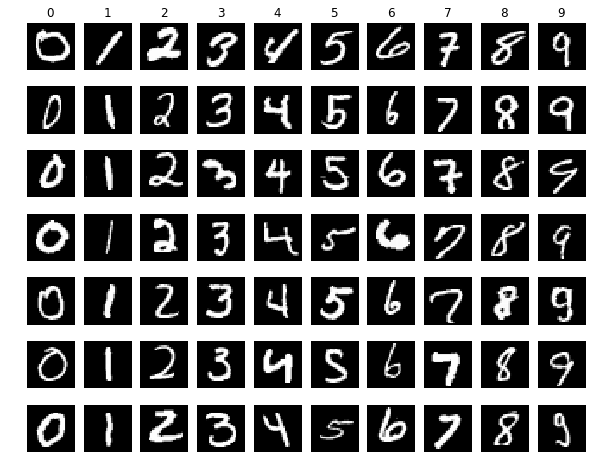

In [4]:
# display random sample of images
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

num_classes = 10
samples_per_class = 7
for cls in range(num_classes):
    idxs = np.flatnonzero(y == cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + cls + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# prep the data for training

# one hot encode labels
y_oh = to_categorical(y, num_classes)

# convert pixel values to be between -1 and 1
X_norm = X / 127.5 - 1
X_norm = np.expand_dims(X_norm, -1) # channels last

# split data into train and validation sets
num_val = int(y.shape[0] * 0.1)
validation_mask = np.zeros(y.shape[0], np.bool)
np.random.seed(1)
for c in range(num_classes):
    idxs = np.random.choice(np.flatnonzero(y == c), num_val // 10, replace=False)
    validation_mask[idxs] = 1
np.random.seed(None)  
    
X_train = X_norm[~validation_mask]
X_val = X_norm[validation_mask]
print(X_train.shape, X_val.shape)

y_train = y_oh[~validation_mask]
y_val = y_oh[validation_mask]
print(y_train.shape, y_val.shape)

# confirm validation set is balanced across classes
print(np.bincount(y[validation_mask]))

(37800, 28, 28, 1) (4200, 28, 28, 1)
(37800, 10) (4200, 10)
[420 420 420 420 420 420 420 420 420 420]


#### Useful Classes / Functions

In [6]:
class LinearDecay(keras.callbacks.Callback):
    '''
    Rate of change = (lr0 - end_lr) / M
    '''
    def __init__(self, M=None, end_lr=0, min_lr=0.0001, rate_of_change=None):
        self.i = 1
        self.M = M
        self.lr0 = None
        self.end_lr = end_lr
        self.min_lr = min_lr  
        self.rate_of_change = rate_of_change
        
    def on_train_begin(self, logs=None):    
        lr = K.get_value(self.model.optimizer.lr)                                 
        if self.lr0 is None:
            self.lr0 = lr
        else:
            print('Learning rate is %s.' % (lr))
        if self.rate_of_change is None:
            self.rate_of_change = (self.lr0 - self.end_lr) / self.M
        
    def on_batch_end(self, batch, logs=None):
        lr = self.lr0 - self.rate_of_change * self.i  
        self.i += 1
        if lr > self.min_lr:
            K.set_value(self.model.optimizer.lr, lr)
        else:
            K.set_value(self.model.optimizer.lr, self.min_lr)
            
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        
        
def plot_training_log(log, acc=True, loss=True, lr=True, figsize=(10.0, 2.5)):
    """Plot training history.
    
    # Arguments
        log: Dictionary of training history, same as ` History.history`  that  
            is returned when fitting a Keras model. Should have records for 'acc', 
            'val_acc', 'loss', 'val_loss', and optionally 'lr'.
        acc: if true, plot both 'acc' and 'val_acc' on one plot.
        loss: if true, plot both 'loss' and 'val_loss' on one plot.
        lr: if true, and if 'lr' is in log, plot both 'lr' and 'val_acc' on one plot.
        figsize: size of each plot.
    """
    
    plt.rcParams['figure.figsize'] = figsize
    max_val_acc_epoch = log['val_acc'].idxmax() + 1
    
    def plot(ytype, ylabel, max_val_acc_epoch):
        plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
        plt.plot(log['epoch'], log[ytype], label='Train')
        plt.plot(log['epoch'], log['val_' + ytype], label='Validation')
        plt.minorticks_on()
        plt.grid(b=True, axis='x', which='both', color='0.8', linestyle='-')
        plt.xlabel('Epoch')
        plt.ylabel(ylabel)
        plt.xlim(0, log['epoch'].iloc[-1] + 1)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    if acc:
        plot('acc', 'Accuracy', max_val_acc_epoch)
        
    if loss:
        plot('loss', 'Loss', max_val_acc_epoch)
    
    if lr and 'lr' in log.columns:
        fig, ax1 = plt.subplots()
        plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')

        ln1 = ax1.plot(log['epoch'], log['lr'], 'C4o-', label='Learning Rate')   
        ax1.set_xticks(log['epoch'], minor=True)
        ax1.grid(b=True, axis='x', which='both', color='0.8', linestyle='-')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Learning Rate')
        ax1.set_xlim(0, log['epoch'].iloc[-1] + 1)

        ax2 = ax1.twinx()
        ln2 = ax2.plot(log['epoch'], log['val_acc'], 'C1o-', 
                       label='Validation Accuracy [0.98 - 1.0]')        
        #ax2.set_ylabel('Val Accuracy')
        ax2.set_yticks([])
        ax2.set_ylim(0.98, 1.0)        

        lns = ln1 + ln2
        plt.legend(lns, [l.get_label() for l in lns])
        plt.tight_layout()
        plt.show()
        
        
def evaluate_model(model, X, y, log=None, pre_train_weights=None):
    """Display accuracy, display misclassified digits, and visualize weights in 
    first convolution layer for the given model with X and y as prediction inputs.
    Optionally, accuracy and loss is plotted with the log argument and additional
    weights can be visualized with the pre_train_weights argument.
    
    # Arguments
        model: Keras model with first convolution layer named 'conv_1'.
        X: Numpy array of MNIST digits, in channels last format.
        y: Labels for X.
        log: (optional) Dictionary of training history, same as ` History.history`  that  
            is returned when fitting a Keras model. Should have records for 'acc', 
            'val_acc', 'loss', 'val_loss', and optionally 'lr'.
        pre_train_weights: (optional) Numpy array of weights in first convolution layer 
            of the model.
    """
    
    scores = model.predict(X)
    predictions = np.argmax(scores, axis=1)
    y_digits = np.nonzero(y)[1]
       
    print("Accuracy:",  np.mean(predictions == y_digits))

    if log is not None:
        plot_training_log(log)

    post_train_weights = model.get_layer('conv_1').get_weights()[0]
    post_train_weights = post_train_weights.transpose(3, 2, 0, 1)
    num_weights = len(post_train_weights)
    if pre_train_weights is not None:
        plt.rcParams['figure.figsize'] = (10.0, 3.0)
        for i in range(num_weights):
            plt.subplot(4, num_weights // 4, i + 1)
            ker = pre_train_weights[i, 0]
            low, high = np.amin(ker), np.max(ker)
            plt.imshow(255 * (ker - low) / (high - low))
            plt.axis('off')
        plt.suptitle('Pre-Training Weights from First Convolutional Layer')
        plt.show()
    plt.rcParams['figure.figsize'] = (10.0, 3.0)
    for i in range(num_weights):
        plt.subplot(4, num_weights // 4, i + 1)
        ker = post_train_weights[i, 0]
        low, high = np.amin(ker), np.max(ker)
        plt.imshow(255 * (ker - low) / (high - low))
        plt.axis('off')
    plt.suptitle('Post-Training Weights from First Convolutional Layer')
    plt.show()

    misclassified_mask = (predictions != y_digits)
    samples_per_class = 7
    num_classes = 10
    plt.rcParams['figure.figsize'] = (10.0, 7.0)    
    counts = [];
    for cls in range(10):
        idxs = np.flatnonzero(y_digits[misclassified_mask] == cls)
        counts.append(len(idxs))
        if len(idxs) > samples_per_class:
            idxs = np.random.choice(idxs, samples_per_class, replace=False)       
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + cls + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X[misclassified_mask][idx,:,:,0])
            plt.axis('off')
            plt.text(14, 27, 'Pred:' + str(predictions[misclassified_mask][idx]), 
                     horizontalalignment='center', verticalalignment='top')        
            if i == 0:
                plt.title(cls)            
    plt.suptitle('Misclassified Digits | Norm of Counts = ' + str(np.linalg.norm(counts)))
    plt.show()

### Inception Modules

In [7]:
def conv2D(x, filters, kernel_size, strides, padding='valid', kernel_initializer='glorot_uniform', batch_norm=True):
    if batch_norm:
        x = layers.Conv2D(filters=filters, 
                          kernel_size=kernel_size, 
                          strides=strides, 
                          padding=padding, 
                          kernel_initializer=kernel_initializer, 
                          #kernel_constraint=keras.constraints.MaxNorm(4., axis=(0,1,2)),
                          use_bias=False)(x)
        x = layers.BatchNormalization(scale=False)(x)
    else:
        x = layers.Conv2D(filters=filters, 
                          kernel_size=kernel_size, 
                          strides=strides, 
                          padding=padding, 
                          kernel_initializer=kernel_initializer, 
                          use_bias=True)(x)

    return layers.Activation('relu')(x)
    #return layers.PReLU(alpha_initializer=keras.initializers.Constant(value=0.25), alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(x)


def inception_module_A(x, filters=None, dropout=None, kernel_initializer='glorot_uniform', batch_norm=True):
    if filters is None:
        filters = int(x.shape[-1])
    branch_filters = filters // 4
        
    b1 = conv2D(x, 
                filters=(branch_filters // 3) * 2, 
                kernel_size=1, 
                strides=1, 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)
    if dropout is not None:
        #b1 = layers.Dropout(dropout, noise_shape=(1, 1, 1, (branch_filters // 3) * 2))(b1)
        b1 = layers.SpatialDropout2D(dropout)(b1)
    b1 = conv2D(b1, 
                filters=branch_filters, 
                kernel_size=3, 
                strides=1, 
                padding='same', 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)
    
    b2 = conv2D(x, 
                filters=(branch_filters // 3) * 2, 
                kernel_size=1, 
                strides=1, 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)
    if dropout is not None:
        #b2 = layers.Dropout(dropout, noise_shape=(1, 1, 1, (branch_filters // 3) * 2))(b2)
        b2 = layers.SpatialDropout2D(dropout)(b2)        
    b2 = conv2D(b2, 
                filters=branch_filters, 
                kernel_size=3, 
                strides=1, 
                padding='same', 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)
    b2 = conv2D(b2, 
                filters=branch_filters, 
                kernel_size=3, 
                strides=1, 
                padding='same', 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)
        
    b3 = conv2D(x, 
                filters=branch_filters, 
                kernel_size=1, 
                strides=1, 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)
    
    pool = layers.AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(x)
    pool = conv2D(pool, 
                  filters=branch_filters, 
                  kernel_size=1, 
                  strides=1, 
                  kernel_initializer=kernel_initializer, 
                  batch_norm=batch_norm)

    x = layers.concatenate([b1, b2, b3, pool])
    if dropout is not None:
        #x = layers.Dropout(dropout, noise_shape=(1, 1, 1, branch_filters * 4))(x)
        x = layers.SpatialDropout2D(dropout)(x)
    
    return x


def inception_module_B(x, filters=None, dropout=None, kernel_initializer='glorot_uniform', batch_norm=True):
    if filters is None:
        filters = int(x.shape[-1])
    branch_filters = filters // 6
        
    b1 = conv2D(x, 
                filters=(branch_filters // 2) * 3, 
                kernel_size=1, 
                strides=1, 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)
    if dropout is not None:
        #b1 = layers.Dropout(dropout, noise_shape=(1, 1, 1, (branch_filters // 2) * 3))(b1)
        b1 = layers.SpatialDropout2D(dropout)(b1)
        
    b1a = conv2D(b1, 
                 filters=branch_filters, 
                 kernel_size=(1, 3), 
                 strides=1, 
                 padding='same', 
                 kernel_initializer=kernel_initializer, 
                 batch_norm=batch_norm)
    
    b1b = conv2D(b1, 
                 filters=branch_filters, 
                 kernel_size=(3, 1), 
                 strides=1, 
                 padding='same', 
                 kernel_initializer=kernel_initializer, 
                 batch_norm=batch_norm)
    
    b2 = conv2D(x, 
                filters=(branch_filters // 2) * 3, 
                kernel_size=1, 
                strides=1, 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)
    if dropout is not None:
        #b2 = layers.Dropout(dropout, noise_shape=(1, 1, 1, (branch_filters // 2) * 3))(b2)    
        b2 = layers.SpatialDropout2D(dropout)(b2)  
    b2 = conv2D(b2, 
                filters=(branch_filters // 4) * 7, 
                kernel_size=(1, 3), 
                strides=1, 
                padding='same', 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)
    b2 = conv2D(b2, 
                filters=branch_filters * 2, 
                kernel_size=(3, 1), 
                strides=1, 
                padding='same', 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)

    b2a = conv2D(b2, 
                 filters=branch_filters, 
                 kernel_size=(1, 3), 
                 strides=1, 
                 padding='same', 
                 kernel_initializer=kernel_initializer, 
                 batch_norm=batch_norm)
    
    b2b = conv2D(b2, 
                 branch_filters, 
                 kernel_size=(3, 1), 
                 strides=1, 
                 padding='same', 
                 kernel_initializer=kernel_initializer, 
                 batch_norm=batch_norm)
        
    b3 = conv2D(x, 
                filters=branch_filters, 
                kernel_size=1, 
                strides=1, 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)
    
    pool = layers.AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(x)
    pool = conv2D(pool, 
                  filters=branch_filters, 
                  kernel_size=1, 
                  strides=1, 
                  kernel_initializer=kernel_initializer, 
                  batch_norm=batch_norm)
    
    x = layers.concatenate([b1a, b1b, b2a, b2b, b3, pool])
    if dropout is not None:
        #x = layers.Dropout(dropout, noise_shape=(1, 1, 1, branch_filters * 6))(x)
        x = layers.SpatialDropout2D(dropout)(x)
    
    return x


def reduction_module(x, filters, padding='same', batch_norm=True):
    branch_filters = (filters - int(x.shape[-1])) // 2
        
    b1 = conv2D(x, (branch_filters // 3) * 2, 1, strides=1, batch_norm=batch_norm)
    b1 = conv2D(b1, branch_filters, 3, strides=2, padding=padding, batch_norm=batch_norm)
    
    b2 = conv2D(x, (branch_filters // 3) * 2, 1, strides=1, batch_norm=batch_norm)
    b2 = conv2D(b2, branch_filters, 3, strides=1, padding='same', batch_norm=batch_norm)
    b2 = conv2D(b2, branch_filters, 3, strides=2, padding=padding, batch_norm=batch_norm)
    
    pool = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding=padding)(x)
    #pool = conv2D(pool, branch_filters, 1, strides=1, batch_norm=batch_norm)

    return layers.concatenate([b1, b2, pool])

### Label Probabilities

In [8]:
# label smoothing
epsilon = 0.001
y_train_smooth = y_train * (1 - epsilon) + epsilon / 10
print(y_train_smooth)

[[1.000e-04 9.991e-01 1.000e-04 ... 1.000e-04 1.000e-04 1.000e-04]
 [9.991e-01 1.000e-04 1.000e-04 ... 1.000e-04 1.000e-04 1.000e-04]
 [1.000e-04 9.991e-01 1.000e-04 ... 1.000e-04 1.000e-04 1.000e-04]
 ...
 [1.000e-04 1.000e-04 1.000e-04 ... 9.991e-01 1.000e-04 1.000e-04]
 [1.000e-04 1.000e-04 1.000e-04 ... 1.000e-04 1.000e-04 1.000e-04]
 [1.000e-04 1.000e-04 1.000e-04 ... 1.000e-04 1.000e-04 9.991e-01]]


### Inception Model

In [12]:
K.clear_session()

stem_width = 64
kernel_initializer = 'glorot_uniform'

inputs = layers.Input(shape=X_norm.shape[1:])

#x = layers.ZeroPadding2D(padding=(2,2))(inputs)

x = layers.Conv2D(filters=stem_width, 
                  kernel_size=5, 
                  strides=2, 
                  padding='valid', 
                  use_bias=False, 
                  kernel_initializer=kernel_initializer, 
                  #kernel_constraint=keras.constraints.MaxNorm(4., axis=(0,1,2)),
                  name='conv_1')(inputs)
x = layers.BatchNormalization(scale=False)(x)
x = layers.Activation('relu')(x)
#x = layers.SpatialDropout2D(0.2)(x)

x = inception_module_A(x, filters=int(1.5*stem_width), kernel_initializer=kernel_initializer, batch_norm=True)
#x = layers.SpatialDropout2D(0.3)(x)

x = inception_module_A(x, filters=int(1.5*stem_width), kernel_initializer=kernel_initializer, batch_norm=True)
#x = layers.SpatialDropout2D(0.3)(x)

x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

x = inception_module_B(x, filters=int(2.25*stem_width), kernel_initializer=kernel_initializer, batch_norm=True)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(num_classes, name='logits')(x)
x = layers.Activation('softmax', name='softmax')(x)

model = Model(inputs=inputs, outputs=x)
model.compile(loss='categorical_crossentropy', 
              #optimizer=optimizers.SGD(lr=0.04, momentum=0.5, nesterov=True),
              #optimizer=optimizers.RMSprop(lr=0.045, rho=0.9, epsilon=1.0, clipvalue=2.0), # incep v3 paper setting max out at .9940, weight vis still noisy after 100 epochs
              #optimizer=optimizers.Adam(lr=0.02, beta_1=0.9, beta_2=0.999),
              optimizer=optimizers.Adamax(lr=0.01, beta_1=0.49, beta_2=0.999),
              metrics=['accuracy'])
model.summary()

# save weights for visualization
pre_train_weights = model.get_layer('conv_1').get_weights()[0]
pre_train_weights = pre_train_weights.transpose(3, 2, 0, 1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 12, 12, 64)   1600        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 12, 12, 64)   192         conv_1[0][0]                     
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 12, 12, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_3 (

## Training

In [25]:
# used when saving results to file, see "Save Results" section
optimizer_args = "(lr=0.01, beta_1=0.49, beta_2=0.999)"
dropout_type = "spatial"
dropout_rates = "(0,0,0,.2)"
annealer_args = "(max_lr=0.01, min_lr=0.0, T=10, T_mul=1)"
notes = "2nd 60 epochs, stem_width=64, A_width=96, B_width=144, only elastic_transform(alpha_range=[8, 10], sigma=3),\
 width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1"

In [14]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha_range, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)
        
    alpha = np.random.uniform(low=alpha_range[0], high=alpha_range[1])

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

In [15]:
class CosineAnneal(keras.callbacks.Callback):
    def __init__(self, max_lr, min_lr, T, T_mul=1):
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.T = T
        self.T_cur = 0
        self.T_mul = T_mul
        self.step = 0
        
    def on_batch_begin(self, batch, logs=None):
        if self.T <= self.T_cur:
            self.T *= self.T_mul
            self.T_cur = 0
            self.step = 0
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(self.T_cur * np.pi / self.T))        
        K.set_value(self.model.optimizer.lr, lr)
        # use self.step to avoid floating point arithmetic errors at warm restarts
        self.step += 1
        self.T_cur = self.step / self.params['steps']
        #print("\n", batch, ":", K.get_value(self.model.optimizer.lr))
            
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [16]:
batch_size = 64
epochs = 60
examples = y_train.shape[0]
time_id = time.strftime("%Y-%m-%d_%H-%M-%S")
log_filename = time_id + '.csv'

# setup callbacks
def exp_decay(epoch, lr, rate=0.94, min_lr=0.001):
    """Exponential decay every 2 epochs"""
    if epoch % 2 or epoch == 0:
        return lr
    return max(lr * rate, min_lr)

def step_decay(epoch, lr, step_size=0.001, min_lr=0.001):
    """Decay by step_size every epoch"""
    if epoch == 0:
        return lr
    return max(lr - step_size, min_lr)

#annealer = None
#annealer = LinearDecay(rate_of_change=3e-06, min_lr=1e-04)
#annealer = LinearDecay(M=(examples // batch_size + 1) * epochs, end_lr=0.035, min_lr=0.001)
#annealer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.0001, verbose=1)
#annealer = keras.callbacks.LearningRateScheduler(step_decay, verbose=0)
annealer = CosineAnneal(max_lr=0.01, min_lr=0.0, T=10, T_mul=1)
chkpt = keras.callbacks.ModelCheckpoint('./mnist-inception-chkpt-{epoch:02d}-{val_acc:.4f}_' + time_id + '.hdf5',
                                        save_best_only=True, monitor='val_acc', verbose=False)
chkpt.best = 0.9959 # don't save models with val_acc under this threshold
csv_logger = keras.callbacks.CSVLogger('logs/' + log_filename, append=True)

preprocessing_function = lambda x: elastic_transform(x, alpha_range=[8, 10], sigma=3)

# define data augmentations
datagen = ImageDataGenerator(
    #rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #shear_range=15,
    zoom_range=0.1,
    preprocessing_function=preprocessing_function
)

history = model.fit_generator(
    datagen.flow(X_train, y_train_smooth, batch_size=batch_size, shuffle=True),
    epochs=epochs,
    steps_per_epoch=591,
    validation_data=(X_val, y_val),
    callbacks=[annealer, chkpt, csv_logger]
)

Epoch 1/60
591/591 [==============================] - 350s 592ms/step - loss: 0.2093 - acc: 0.9439 - val_loss: 0.1354 - val_acc: 0.9576
Epoch 2/60
591/591 [==============================] - 372s 630ms/step - loss: 0.0907 - acc: 0.9759 - val_loss: 0.0709 - val_acc: 0.9814
Epoch 3/60
591/591 [==============================] - 373s 630ms/step - loss: 0.0734 - acc: 0.9813 - val_loss: 0.0399 - val_acc: 0.9895
Epoch 4/60
591/591 [==============================] - 370s 626ms/step - loss: 0.0630 - acc: 0.9840 - val_loss: 0.0365 - val_acc: 0.9879
Epoch 5/60
591/591 [==============================] - 363s 614ms/step - loss: 0.0521 - acc: 0.9873 - val_loss: 0.0376 - val_acc: 0.9886
Epoch 6/60
591/591 [==============================] - 361s 611ms/step - loss: 0.0459 - acc: 0.9896 - val_loss: 0.0311 - val_acc: 0.9914
Epoch 7/60
591/591 [==============================] - 356s 603ms/step - loss: 0.0388 - acc: 0.9916 - val_loss: 0.0261 - val_acc: 0.9938
Epoch 8/60
591/591 [============================

In [22]:
history = model.fit_generator(
    datagen.flow(X_train, y_train_smooth, batch_size=batch_size, shuffle=True),
    epochs=epochs,
    steps_per_epoch=591,
    validation_data=(X_val, y_val),
    callbacks=[annealer, chkpt, csv_logger]
)

Epoch 1/60
591/591 [==============================] - 359s 608ms/step - loss: 0.0307 - acc: 0.9939 - val_loss: 0.0363 - val_acc: 0.9917
Epoch 2/60
591/591 [==============================] - 359s 607ms/step - loss: 0.0293 - acc: 0.9945 - val_loss: 0.0290 - val_acc: 0.9917
Epoch 3/60
591/591 [==============================] - 360s 609ms/step - loss: 0.0283 - acc: 0.9951 - val_loss: 0.0288 - val_acc: 0.9936
Epoch 4/60
591/591 [==============================] - 358s 605ms/step - loss: 0.0287 - acc: 0.9952 - val_loss: 0.0274 - val_acc: 0.9924
Epoch 5/60
591/591 [==============================] - 355s 601ms/step - loss: 0.0254 - acc: 0.9956 - val_loss: 0.0286 - val_acc: 0.9938
Epoch 6/60
591/591 [==============================] - 354s 600ms/step - loss: 0.0241 - acc: 0.9964 - val_loss: 0.0227 - val_acc: 0.9950
Epoch 7/60
591/591 [==============================] - 366s 620ms/step - loss: 0.0224 - acc: 0.9970 - val_loss: 0.0237 - val_acc: 0.9950
Epoch 8/60
591/591 [============================

### Model Evaluation

Accuracy: 0.9952380952380953


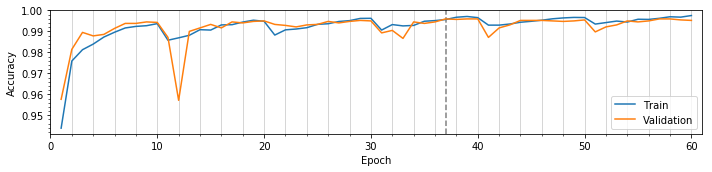

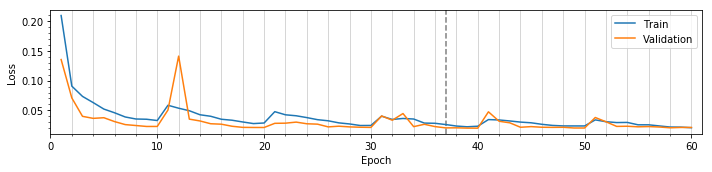

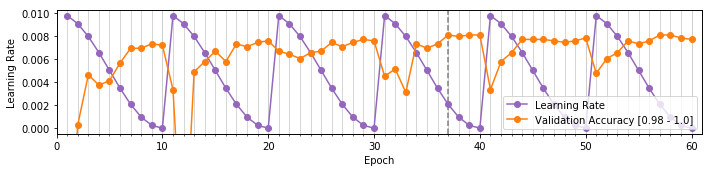

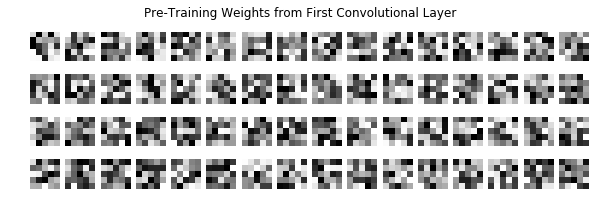

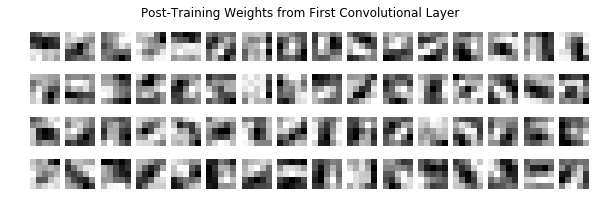

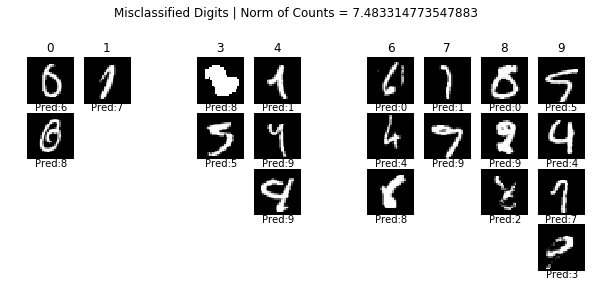

In [17]:
# 1st 60 epochs
log = pd.read_csv('logs/' + log_filename)
log['epoch'] += 1
evaluate_model(model, X_val, y_val, log=log, pre_train_weights=pre_train_weights)

Accuracy: 0.9947619047619047


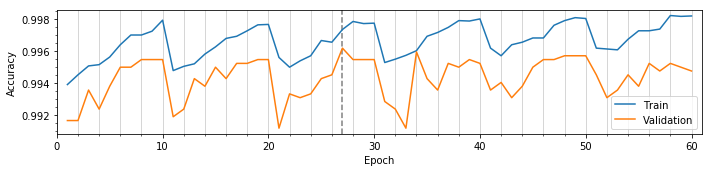

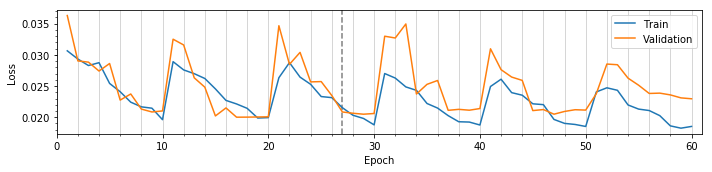

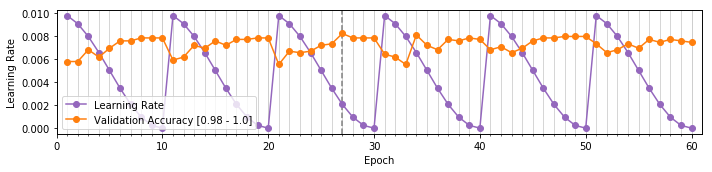

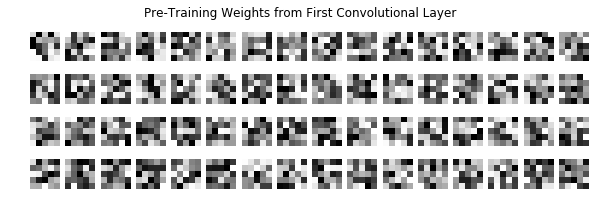

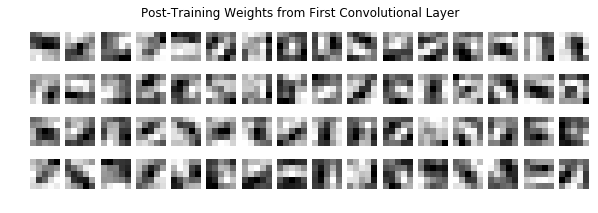

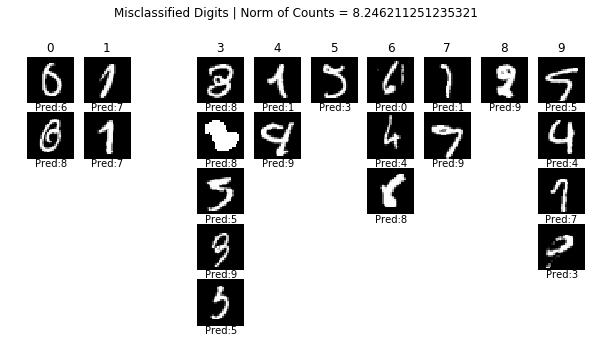

In [23]:
# 2nd 60 epochs
log = pd.read_csv('logs/' + log_filename)
log['epoch'] += 1
evaluate_model(model, X_val, y_val, log=log, pre_train_weights=pre_train_weights)

#### Best Models

Accuracy: 0.9959523809523809


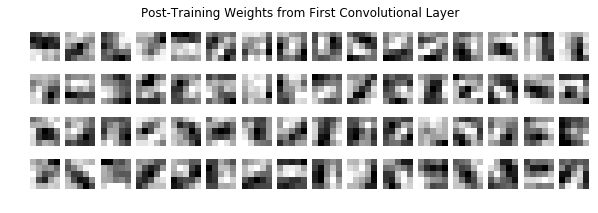

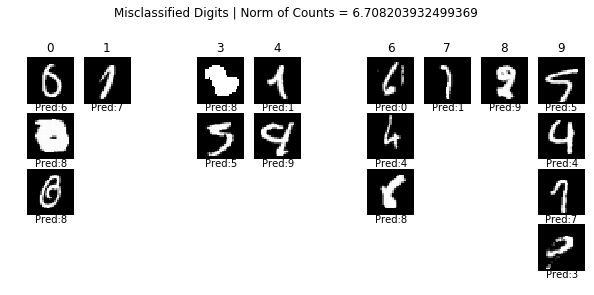

In [21]:
# best model 1st 60 epochs
model2 = keras.models.load_model('./mnist-inception-chkpt-37-0.9960_2018-11-25_01-29-15.hdf5')
evaluate_model(model2, X_val, y_val)

Accuracy: 0.9961904761904762


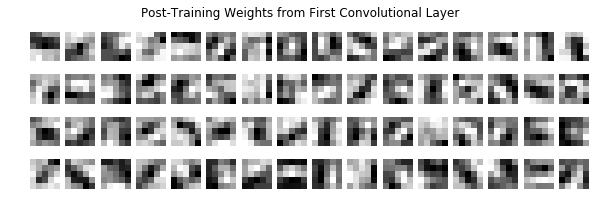

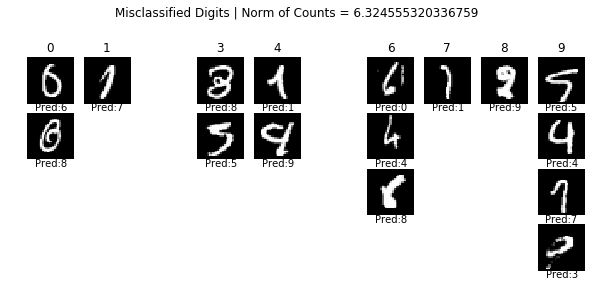

In [24]:
# best model 2nd 60 epochs
model2 = keras.models.load_model('./mnist-inception-chkpt-27-0.9962_2018-11-25_01-29-15.hdf5')
evaluate_model(model2, X_val, y_val)

Some other decent models for comparison.

Accuracy: 0.9952380952380953


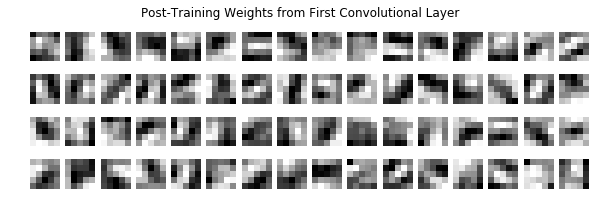

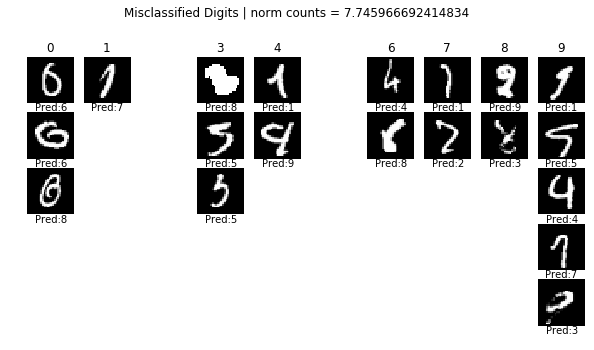

In [13]:
model = keras.models.load_model('./mnist-inception-chkpt-12-0.9952_2018-11-15_20-02-30.hdf5')
evaluate_model(model, X_val, y_val)

Accuracy: 0.9952380952380953


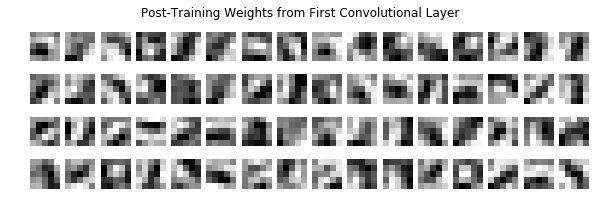

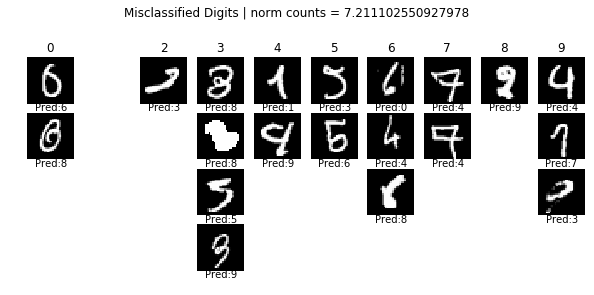

In [15]:
model = keras.models.load_model('./mnist-inception-chkpt-48-0.9952_2018-10-26_22-46-37.hdf5')
evaluate_model(model, X_val, y_val)

### Save Results

In [26]:
new_result = {}

i = log['val_acc'].idxmax()
new_result['val_acc'] = round(log['val_acc'][i], 4)
new_result['val_loss'] = round(log['val_loss'][i], 4)
if 'lr' in log.keys():
    new_result['lr'] = log['lr'][i]
new_result['epoch'] = i + 1

new_result['optimizer'] = model.optimizer.__class__.__name__
new_result['optimizer args'] = optimizer_args

if annealer is None:
    new_result['annealer'] = ''
    new_result['lr'] = K.get_value(model.optimizer.lr)
else:
    new_result['annealer'] = annealer.__class__.__name__
    if new_result['annealer'] == 'LearningRateScheduler':
        new_result['annealer'] = annealer.schedule.__doc__    
new_result['annealer args'] = annealer_args

new_result['dropout type'] = dropout_type
new_result['dropout rates'] = dropout_rates

new_result['notes'] = notes

new_result['batch size'] = batch_size
new_result['epochs'] = len(log['acc'])

new_result['log'] = log_filename

new_result['keras'] = keras_version
new_result['tf'] = tf_version

new_result

{'val_acc': 0.9962,
 'val_loss': 0.0208,
 'lr': 0.0020632243,
 'epoch': 27,
 'optimizer': 'Adamax',
 'optimizer args': '(lr=0.01, beta_1=0.49, beta_2=0.999)',
 'annealer': 'CosineAnneal',
 'annealer args': '(max_lr=0.01, min_lr=0.0, T=10, T_mul=1)',
 'dropout type': 'spatial',
 'dropout rates': '(0,0,0,.2)',
 'notes': '2nd 60 epochs, stem_width=64, A_width=96, B_width=144, only elastic_transform(alpha_range=[8, 10], sigma=3), width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1',
 'batch size': 64,
 'epochs': 60,
 'log': '2018-11-25_01-29-15.csv',
 'keras': '2.2.4',
 'tf': '1.12.0'}

In [27]:
results = pd.read_csv('results.csv')
new_results = results.append(new_result, ignore_index=True)
new_results.iloc[[-1]]

,val_acc,val_loss,lr,epoch,optimizer,optimizer args,annealer,annealer args,dropout type,dropout rates,notes,batch size,epochs,log,keras,tf
139,0.9962,0.0208,0.002063,27,Adamax,"(lr=0.01, beta_1=0.49, beta_2=0.999)",CosineAnneal,"(max_lr=0.01, min_lr=0.0, T=10, T_mul=1)",spatial,"(0,0,0,.2)","2nd 60 epochs, stem_width=64, A_width=96, B_width=144, only elastic_transform(alpha_range=[8, 10], sigma=3), width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1",64,60,2018-11-25_01-29-15.csv,2.2.4,1.12.0


Overwrite results.csv?

In [28]:
results_filename = 'results.csv'
prompt = "Type y to save updated results to " + results_filename + ": "
overwrite = input(prompt)
if overwrite == 'y':
    new_results.to_csv(results_filename, index=False, float_format='%.4f')
    print(results_filename, "saved")
else:
    print(results_filename, "not saved")

Type y to save updated results to results.csv: y
results.csv saved


### Predict on Test Set

In [28]:
# load test set data
test_data = np.loadtxt('test.csv', dtype=int, delimiter=',', skiprows=1)

In [35]:
# inspect data
print("Raw data shape:", test_data.shape)

# convert pixel values to 2d arrays
test_images = np.reshape(test_data, (28000, 28, 28))
test_images = test_images / 127.5 - 1
test_images = np.expand_dims(test_images, -1)
print("Pixels reshaped shape:", test_images.shape)

Raw data shape: (28000, 784)
Pixels reshaped shape: (28000, 28, 28, 1)


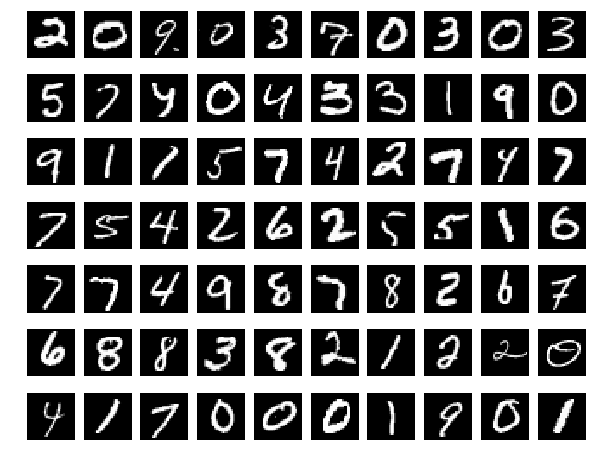

In [61]:
# display random sample of images
plt.rcParams['figure.figsize'] = (10.0, 8.0)
for i in range(70):
    plt.subplot(7, 10, i + 1)
    plt.imshow(test_images[i,:,:,0])
    plt.axis('off')
plt.show()

In [39]:
test_scores = model.predict(test_images)
test_predictions = np.argmax(test_scores, axis=1)

In [64]:
header = 'ImageId,Label'
submission = np.stack((range(1, 28001), test_predictions), axis=1)
print(submission.shape)
np.savetxt('submission.csv', submission, fmt='%i', delimiter=',', header=header, comments='')

(28000, 2)
